# Python implementation of CBOW and Skip-gram

### Here, I will show you how to implement word2vec using the standard Python library, NumPy and two utility functions from Keras

### STEP 1: Requirements:
    - Python version: 3.6
    - Numpy version: 1.14.2
    - keras version: 2.1.5 [It is used because of a few useful NLP tools (Tokenizer, sequence and np_utils)]

In [12]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
import tensorflow as tf

### STEP 2: From corpus to center and context words
    - The first step in our implementation is to transform a text corpus into numbers. Specifically, into one-hot encoded vectors. Recall that in word2vec we scan through a text corpus and for each training example we define a center word with its surrounding context words. Depending on the algorithm of choice (Continuous Bag-of-Words or Skip-gram), the center and context words may work as inputs and labels, respectively, or vice versa.
    - Typically the context words are defined as a symmetric window of predefined length, on both the left and right hand sides of the center word. For example, suppose our corpus consists of the sentence “I like playing football with my friends”. Also, let’s say that we define our window to be symmetric around the center word and of length two. Then, our one-hot encoded context and center words can be visualized as follows,

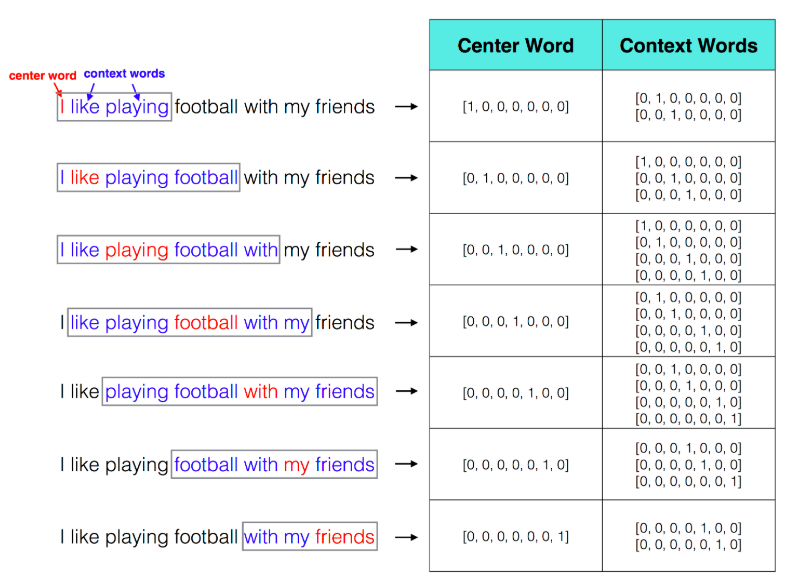

We first we need to tokenize the corpus text to accomplish this mapping, from text to one-hot-encoded vectors, as displayed in the figure above.

Tokenize the corpus text:
    - param corpus: list containing a string of text (example: ["I like playing football with my friends"])
    - return corpus_tokenized: indexed list of words in the corpus, in the same order as the original corpus (the example above would return [[1, 2, 3, 4]])
    - return V: size of vocabulary

In [96]:
def tokenize(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    corpus_tokenized = tokenizer.texts_to_sequences(corpus)
    V = len(tokenizer.word_index)
    return corpus_tokenized, V

Now, mapping from text to one-hot encoded context and center words using the function corpus2io which uses the auxiliary function to_categorical (copied from the Keras repository).
Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
        - Arguments
            - y: class vector to be converted into a matrix(integers from 0 to num_classes).
            - num_classes: total number of classes.
        - Returns
            - A binary matrix representation of the input.

In [97]:
def to_categorical(y, num_classes=None):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

corpus2io:
    - Converts corpus text into context and center words
        - Arguments
            - corpus_tokenized: corpus text
            - window_size: size of context window
        - Returns
            - context and center words (arrays)

In [98]:
def corpus2io(corpus_tokenized, V, window_size):
    for words in corpus_tokenized:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            center = []
            s = index - window_size
            e = index + window_size + 1
            contexts = contexts + [words[i]-1 for i in range(s, e) if 0 <= i < L and i != index]
            center.append(word-1)
            # x has shape c x V where c is size of contexts
            x = np_utils.to_categorical(contexts, V)
            # y has shape k x V where k is number of center words
            y = np_utils.to_categorical(center, V)
            yield (x, y)

In [100]:
window_size = 2
corpus = ["I like playing football with my friends"]
corpus_tokenized, V = tokenize(corpus)
for i, (x, y) in enumerate(corpus2io(corpus_tokenized, V, window_size)):
    print(i, "\n center word =", y, "\n context words =\n",x)

0 
 center word = [[1. 0. 0. 0. 0. 0. 0.]] 
 context words =
 [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
1 
 center word = [[0. 1. 0. 0. 0. 0. 0.]] 
 context words =
 [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
2 
 center word = [[0. 0. 1. 0. 0. 0. 0.]] 
 context words =
 [[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
3 
 center word = [[0. 0. 0. 1. 0. 0. 0.]] 
 context words =
 [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
4 
 center word = [[0. 0. 0. 0. 1. 0. 0.]] 
 context words =
 [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
5 
 center word = [[0. 0. 0. 0. 0. 1. 0.]] 
 context words =
 [[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
6 
 center word = [[0. 0. 0. 0. 0. 0. 1.]] 
 context words =
 [[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]


### STEP 3: Softmax function
    It calculates softmax based probability for given input vector
        - Arguments
            - x: numpy array/list
        - Returns
            - softmax of input array

In [101]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

### STEP 4: Python code for the Multi-Word CBOW model:
    Implementation of Continuous-Bag-of-Words Word2Vec model
        - param context: all the context words (these represent the inputs)
        - param label: the center word (this represents the label)
        - param W1: weights from the input to the hidden layer
        - param W2: weights from the hidden to the output layer
        - param loss: float that represents the current value of the loss function
        - return: updated weights and loss

In [104]:
def cbow(context, label, W1, W2, loss):
        # context is 'x' from tokenizer, it is a c x V matrix
        # label is 'y' from tokenizer, it is a 1 x V matrix
        
        x = np.matrix(np.mean(context, axis=0))
        
        # x is a 1 x V matrix
        # W1 is a VxN matrix
        # h is a N x 1 matrix
        h = np.matmul(W1.T, x.T)
        
        # u is a V x 1 matrix
        u = np.matmul(W2.T, h)
        
        # W2 is an N x V matrix
        # y_pred is a V x 1 matrix
        y_pred = softmax(u)
        # e is a V x 1 matrix
        e = -label.T + y_pred
        # h is N x 1 and e is V x 1 so dW2 is N x V
        dW2 = np.outer(h, e)
        # x.T is a V x 1 matrix, W2e is a Nx1 so dW1 this is V x N
        dW1 = np.outer(x.T, np.matmul(W2, e))

        new_W1 = W1 - eta * dW1
        new_W2 = W2 - eta * dW2

        # label is a 1xV matrix so label.T is a Vx1 matrix
        loss += -float(u[label.T == 1]) + np.log(np.sum(np.exp(u)))

        return new_W1, new_W2, loss

Usage of above function is shown below:

In [105]:
#user-defined parameters
corpus = ["I like playing football with my friends"] #our example text corpus
N = 2 #assume that the hidden layer has dimensionality = 2
window_size = 2 #symmetrical
eta = 0.1 #learning rate

corpus_tokenized, V = tokenize(corpus)

#initialize weights (with random values) and loss function
np.random.seed(100)
W1 = np.random.rand(V, N)
W2 = np.random.rand(N, V)
loss = 0.

for i, (context, label) in enumerate(corpus2io(corpus_tokenized, V, window_size)):
    W1, W2, loss = cbow(context, label, W1, W2, loss)
    print("Training example #{} \n-------------------- \n\n \t label = {}, \n \t context = {}".format(i, label, context))
    print("\t W1 = {}\n\t W2 = {} \n\t loss = {}\n".format(W1, W2, loss))

Training example #0 
-------------------- 

 	 label = [[1. 0. 0. 0. 0. 0. 0.]], 
 	 context = [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
	 W1 = [[ 0.54340494  0.27836939]
 [ 0.40739238  0.86832668]
 [-0.01240636  0.14511967]
 [ 0.67074908  0.82585276]
 [ 0.13670659  0.57509333]
 [ 0.89132195  0.20920212]
 [ 0.18532822  0.10837689]]
	 W2 = [[2.37522044e-01 9.74588882e-01 8.08598345e-01 1.69452859e-01
  8.13081663e-01 2.71730692e-01 4.28973634e-01]
 [9.80158449e-01 8.08565553e-01 3.29167094e-01 1.69808842e-01
  3.65755980e-01 4.13558689e-04 2.46279033e-01]] 
	 loss = 1.7750419435896188

Training example #1 
-------------------- 

 	 label = [[0. 1. 0. 0. 0. 0. 0.]], 
 	 context = [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
	 W1 = [[5.56639604e-01 2.89686158e-01]
 [4.07392378e-01 8.68326677e-01]
 [8.28305455e-04 1.56436438e-01]
 [6.83983747e-01 8.37169528e-01]
 [1.36706590e-01 5.75093329e-01]
 [8.91321954e-01 2.09202122e-01]
 [1.85328220e-01 1.08376890e

### STEP 5: Python code for the Skip-Gram model:
    In the skip-gram model, the inputs are represented by center words and the labels by context words. The full set of equations that we need to solve are the following:

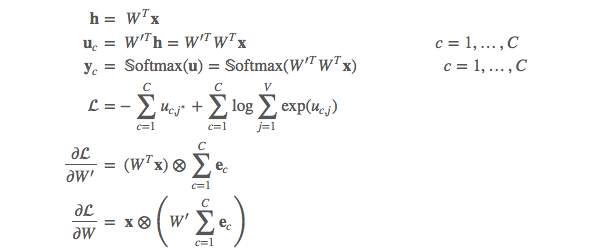

    The update equation for the weights is the same as for the CBOW model,

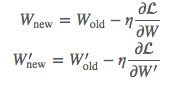

Below is the Python code that solves the equations for the skip-gram model:
    - param context: all the context words (these represent the labels)
    - param x: the center word (this represents the input)
    - param W1: weights from the input to the hidden layer
    - param W2: weights from the hidden to the output layer
    - param loss: float that represents the current value of the loss function
    - return: updated weights and loss

In [107]:
def skipgram(context, x, W1, W2, loss):
        # context is "x" from tokenizer, it is a c x V matrix
        # "x" is "y" from tokenizer, it is a 1 x V matrix
        # W1 has dimension V x N (N= number of features, V = vocab size)
        # x has dimension V x 1
        h = np.matmul(W1.T, x.T)
        # h has dimension N x 1
        # W2 has dimension N x V
        # u has dimension V x 1
        u = np.dot(W2.T, h)
        # y_pred has dimension V x 1
        y_pred = softmax(u)

        # context is a c by V matrix
        # e is a V x c matrix
        e = np.outer(y_pred,np.array([1]*context.shape[0]))-context.T

        # np.sum(e, axis=1) is a V x 1 vectors
        # h is an N x 1 Vector
        # dW2 is a N x V matrix
        dW2 = np.outer(h, np.sum(e, axis=1))
        # x is a V x 1 matrix
        # np.dot(W2, np.sum(e,axis=1)) is a product (N x V) (Vx 1) is Nx1
        # dW1 is an V x N matrix
        dW1 = np.outer(x, np.dot(W2, np.sum(e, axis=1)))

        new_W1 = W1 - eta * dW1
        new_W2 = W2 - eta * dW2

        loss += - np.sum([u[label.T == 1] for label in context]) + len(context) * np.log(np.sum(np.exp(u)))

        return new_W1, new_W2, loss

The function skipgram defined above is used similarly to the cbow function, except that now the center words are no more the “labels” but are actually the inputs and the labels are represented by the context words. Using the same user-defined parameters as for the CBOW case, we can run the same example with the following code:

In [108]:
for i, (label, center) in enumerate(corpus2io(corpus_tokenized, V, window_size)):
    W1, W2, loss = skipgram(label, center, W1, W2, loss)
    print("Training example #{} \n-------------------- \n\n \t label = {}, \n \t center = {}".format(i, label, center))
    print("\t W1 = {}\n\t W2 = {} \n\t loss = {}\n".format(W1, W2, loss))

Training example #0 
-------------------- 

 	 label = [[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]], 
 	 center = [[1. 0. 0. 0. 0. 0. 0.]]
	 W1 = [[ 0.62199038  0.30934835]
 [ 0.40213707  0.85600117]
 [-0.00432069  0.14562168]
 [ 0.68382212  0.81335847]
 [ 0.11156295  0.53410073]
 [ 0.87701927  0.18616941]
 [ 0.17993324  0.08900217]]
	 W2 = [[0.18344406 0.99802854 0.85318831 0.16665383 0.80046283 0.26762708
  0.43454347]
 [0.9294146  0.81215672 0.37164133 0.17961877 0.34761577 0.0164294
  0.24327192]] 
	 loss = 17.236381960861195

Training example #1 
-------------------- 

 	 label = [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]], 
 	 center = [[0. 1. 0. 0. 0. 0. 0.]]
	 W1 = [[ 0.62199038  0.30934835]
 [ 0.34471379  0.85165164]
 [-0.00432069  0.14562168]
 [ 0.68382212  0.81335847]
 [ 0.11156295  0.53410073]
 [ 0.87701927  0.18616941]
 [ 0.17993324  0.08900217]]
	 W2 = [[ 0.20155094  0.97028265  0.87544896  0.19531034  0.7832442   0.25716013
   0.42095089]

Let’s use it and check, for example, that for the context word “like” - or [0, 1, 0, 0, 0, 0, 0] - the model predicts that the center word is “I” - or [1, 0, 0, 0, 0, 0, 0].

In [118]:
def predict( x, W1, W2):
        """Predict output from input data and weights
        :param x: input data
        :param W1: weights from input to hidden layer
        :param W2: weights from hidden layer to output layer
        :return: output of neural network
        """
        h = np.mean([np.matmul(W1.T, xx) for xx in x], axis=0)
        u = np.dot(W2.T, h)
        return softmax(u)
x = np.array([[0, 1, 0, 0, 0, 0, 0]])
y_pred = predict(x, W1, W2)
print(("prediction_cbow = [" + 6*"{:.3e}, " + "{:.3e}]").format(*y_pred))

prediction_cbow = [1.766e-01, 2.018e-01, 1.580e-01, 1.088e-01, 1.461e-01, 9.607e-02, 1.127e-01]


### This is it for now. I hope you enjoyed the reading!